In [1]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
from tabulate import tabulate

<h1>Set Up</h1>
Loading the star data, grouping them by cluster names. <br>
<i>Code provided in the assignment 1 handout.</i>

In [2]:
dr3stars = fits.open('../Data/gaiadr3_cluster_stars.fits')
dr3stars.info()
stars = pd.DataFrame(dr3stars[1].data)

Filename: ../Data/gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
stars['Name'] = stars['Name'].str.strip()
clcounts = stars.groupby(['Name']).size().reset_index(name='count')

<h2>Task 1</h2>
Below we define a function that can create the mutlivariate plot that we need. <br>
<i>Heavy inspiration for the code was taken from the tutorial <a href="https://philuttley.github.io/stats-methods-24/pandas_plotting/index.html">here</a></i>

In [31]:
def multivariate_plot(stars, cluster_name, to_plot, labels=None):
    """
    Function that takes in the star data data frame, splits into the requried 10 samples and plots a multivariate plots of them.
    stars:
    - dataframe corresponding to the star data
    cluster_name:
    - name of the cluster whose stars need to be selected
    to_plot: 
    - Parameters that needed to be plotted (need to be column names of the star dataframe)
    """
    
    fig, axes = plt.subplots(5,5,figsize=(12,12))
    fig.subplots_adjust(wspace=0.5,hspace=0.5)
    fig.suptitle(f'Scatter plot matrix for {cluster_name}')
    if labels == None:
        labels = to_plot
        
    # Selecting stars in the cluster that have a probability less than or equal to 0.8 and greater than 0.8 of belonging to the cluster.
    prob_lessthan = stars[(stars['Name'] == cluster_name) & (stars['Prob'] <= 0.8)]
    prob_morethan = stars[(stars['Name'] == cluster_name) & (stars['Prob'] > 0.8)]
    for count1 in range(len(to_plot)):
        for count2 in range(len(to_plot)):
            
            if count1 == count2:
                axes[count1, count2].hist(prob_lessthan[to_plot[count1]], alpha=0.5, color='#E56B6F', bins=20, label='P<=0.8')
                axes[count1, count2].hist(prob_morethan[to_plot[count1]], alpha=.5, color='#006D77', bins=20, label='P>0.8')
                
            elif count1 > count2:
                axes[count1,count2].scatter(prob_lessthan[to_plot[count2]], prob_lessthan[to_plot[count1]], s=4, color='#E56B6F', label='P <= 0.8', alpha=0.3)
                axes[count1,count2].scatter(prob_morethan[to_plot[count2]], prob_morethan[to_plot[count1]], s=5, color='#006D77', label='P > 0.8', alpha=0.4)
                
            else:
                axes[count1,count2].axis('off')
            if count1 == 4:
                axes[count1, count2].set_xlabel(labels[count2])
            if count2 == 0:
                if count1 == 0:
                    axes[count1, count2].set_ylabel('Counts') 
                else:
                    axes[count1, count2].set_ylabel(labels[count1])
            if count1 == 1 and count2==0: 
                fig.legend(loc='right') # Plotting legend right after 1 histogram and 1 scatter plot are plotted
    plt.show()

Now we can sample the dataset for the four clusters that we need

In [32]:
ClusterSampledNames = clcounts[clcounts['count'] > 1000].sample(4)['Name']
print(f'Names of Sampled Clusters: \n{ClusterSampledNames}')

Names of Sampled Clusters: 
4867    NGC_7654
4292     IC_2714
4628    NGC_4590
4664    NGC_5904
Name: Name, dtype: object


Then, we can define the parameters that we want to make a multivariate plot of and call the function we defined earlier for each of the sampled clusters. We are plotting scatter plots of each parameter that is specified against each other as well as a histogram of each parameter.

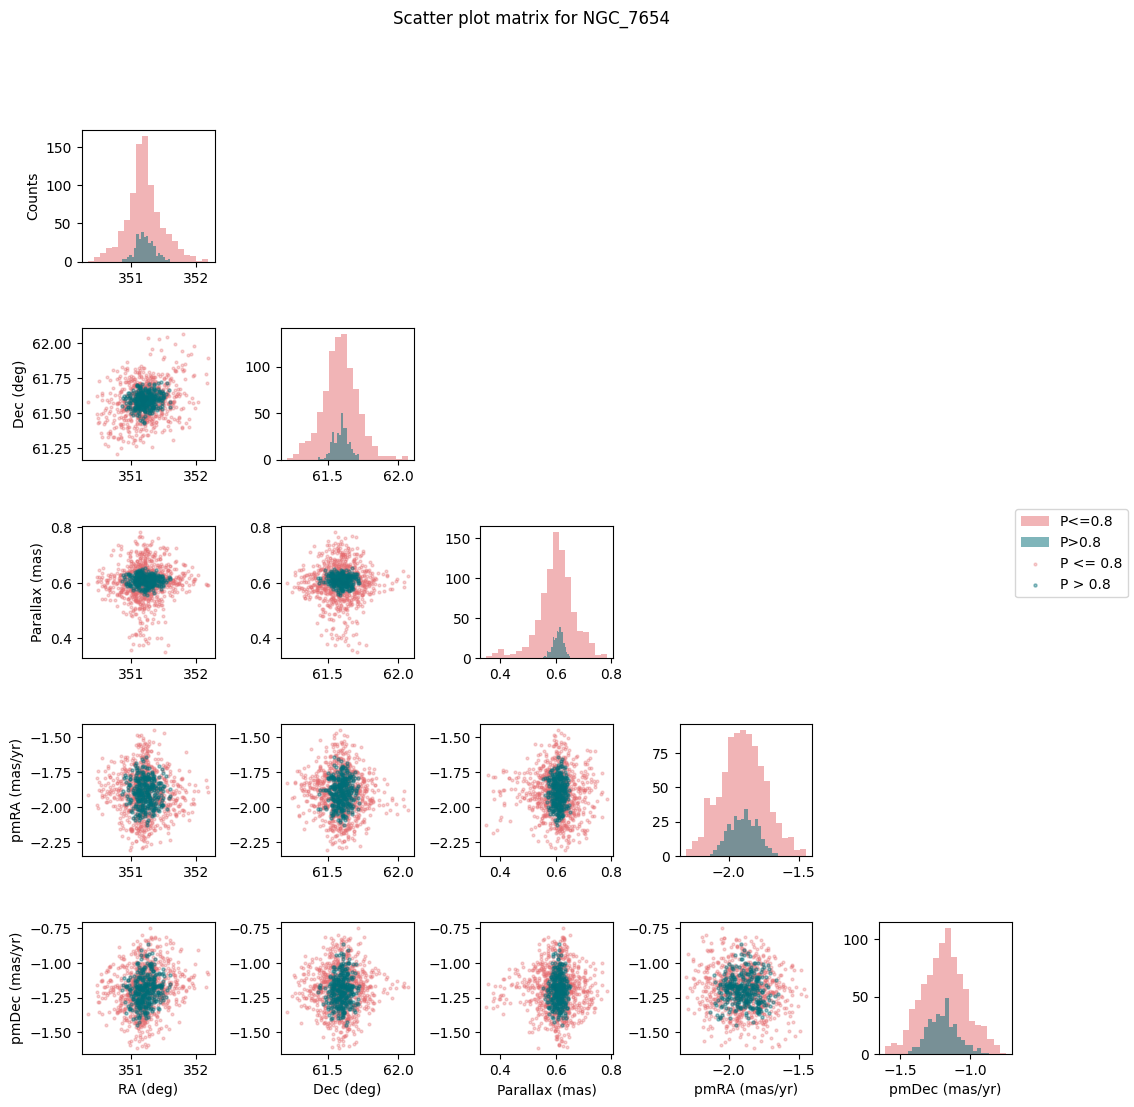

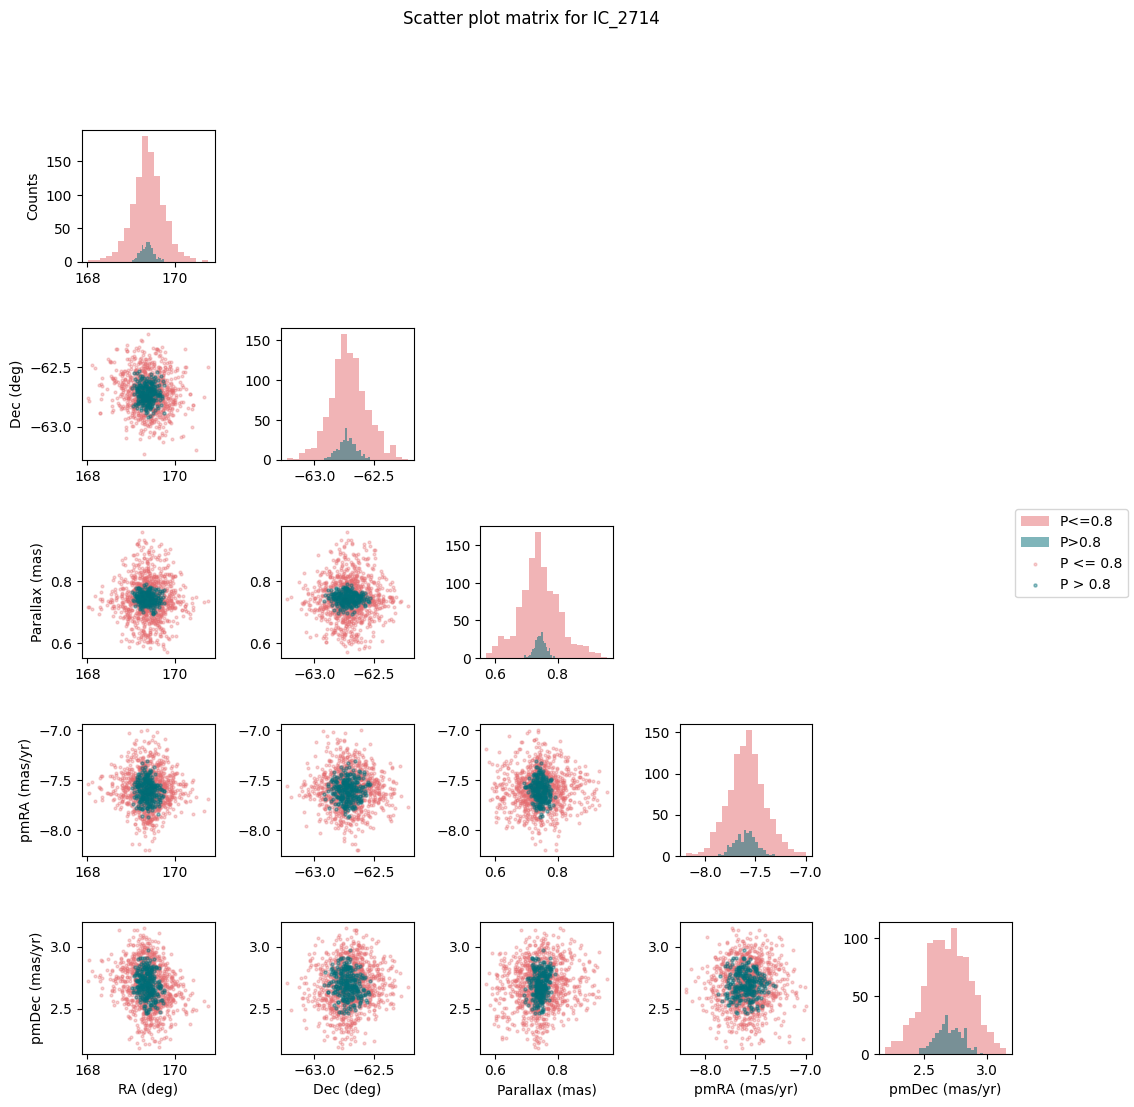

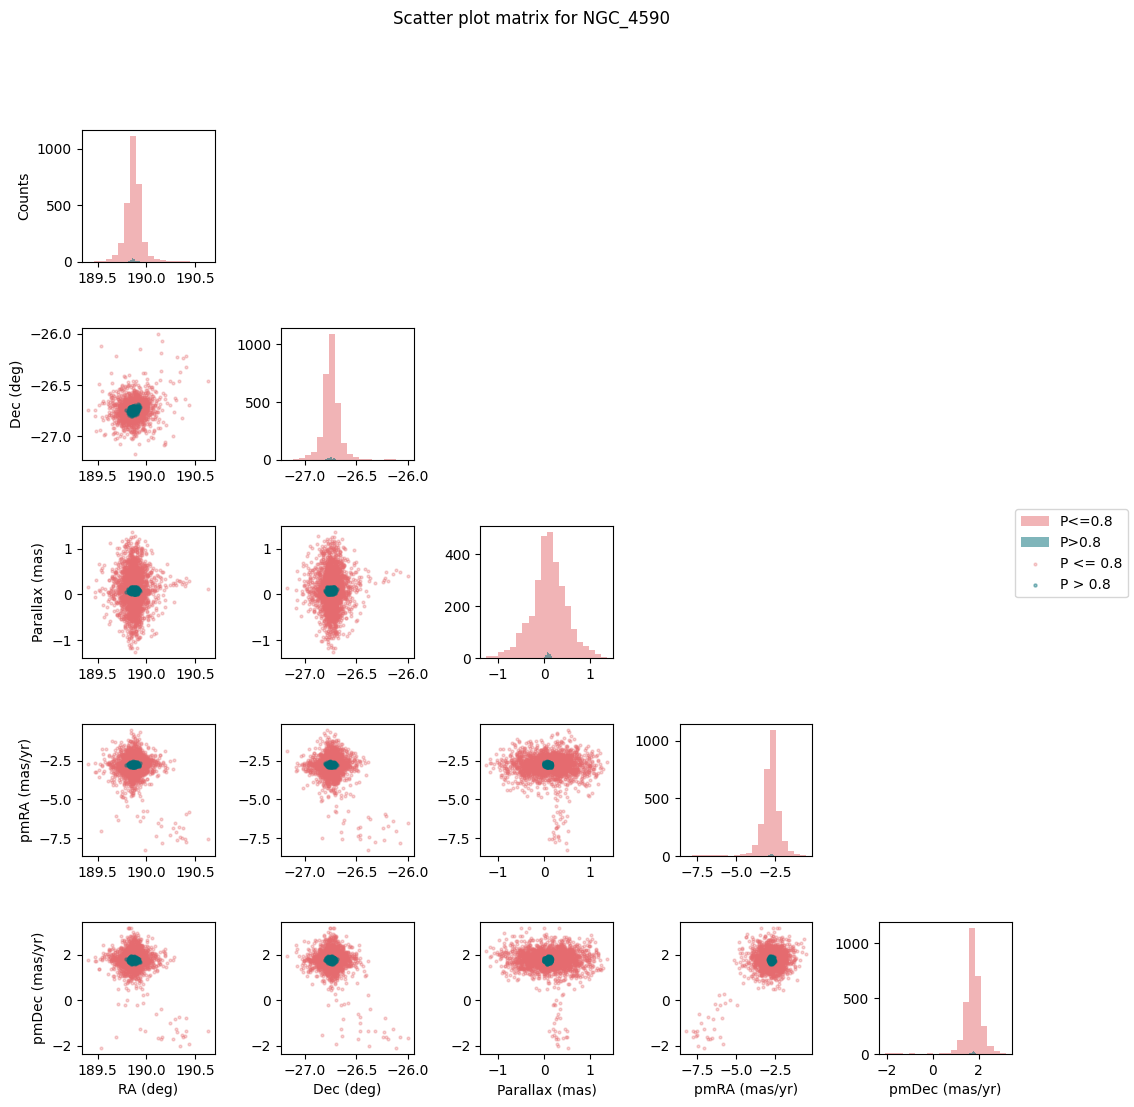

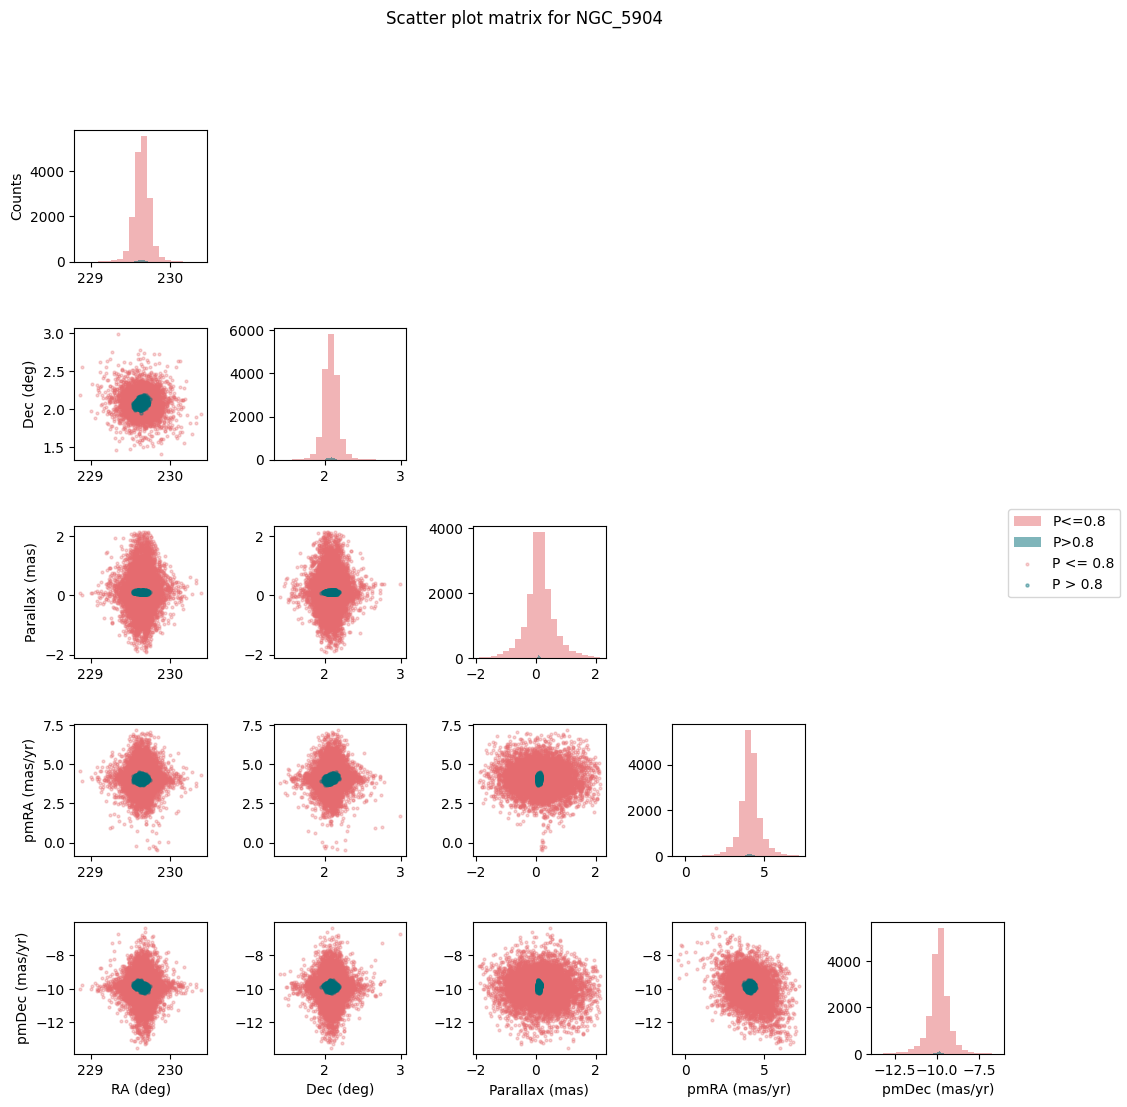

In [33]:
toplot = ['RAdeg', 'DEdeg', 'Plx', 'pmRA', 'pmDE']
labels = ['RA (deg)', 'Dec (deg)', 'Parallax (mas)', 'pmRA (mas/yr)', 'pmDec (mas/yr)']
for name in ClusterSampledNames:
    multivariate_plot(stars, name, toplot, labels)

<h3>Comments on Results</h3>
<b>Names of clusters sampled: NGC 3201, Berkeley 53, NGC 7044 and NGC 6715 <br><br></b>715
A common feature of all the scatter plots is that the stars that make up the higher probability section of the plot are the 'core' of the plot, with the lower probability stars being more spread out. This makes sense as the more you constrain the allowed values, higher the likelihood that the star is part of the cluster. The histgrams for the high probabilities stars also apear to be a scaled down version of the low probaility stars - that is, their shape is approximately the same - which makes sense for the same reason.<br>
The differences between the scatter plots arise from the different ways in which the parameters are related. For example, the RA and DE scatter plot of the cluster Stock 2 is not spherical - this suggests that the cluster itself is not spherical. 

<h1>Task 2</h1>
We are first going to define a function that reduces our data according to the specifications ("Now use the new clusters_hiprob dataframe to make a new cluster sample containing only 
clusters with > 200 stars and standard deviations of RA and Dec < 0.1"). We are not going to call this function yet. 

In [34]:
def red_data(stars):
    """
    Selects stars with P > 0.8 and clusters with sd < 0.1 in RA and DE
    Parameters
    -------------
    Stars: pandas datafram
    - Has the complete data frame of stars
    
    Returns
    --------------
    clusters_hiprob: pandas dataframe
    - dataframe of clusters' names, their std in RA and DE and the count of stars with P>0.8
    stars_hiprob: pandas dataframe
    - Dataframe of selected stars with P > 0.8 of belonging to their respective cluster
    """
    # Below is code taken from the assignment handout
    stars_hiprob = stars[stars.Prob > 0.8]
    clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='count')
    clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()
    clusters_hiprob['sd_RAdeg'] = clusters_sd_hiprob['RAdeg']
    clusters_hiprob['sd_DEdeg'] = clusters_sd_hiprob['DEdeg']

    # Below is my code to select clusters based in sd and number of stars
    clusters_hiprob_selected = clusters_hiprob[(clusters_hiprob['count'] > 200) & (clusters_sd_hiprob['DEdeg'] < 0.1) & (clusters_sd_hiprob['RAdeg'] < 0.1)]
    
    return clusters_hiprob_selected, stars_hiprob

Now we can move onto the t tests. We are going to define a function that splits our star data, for a given cluster (as in, the name of the cluster is given) into two subsamples each for RA and DEC (greater than mean and less than mean). Then, we plot histograms of each of these subsamples against each other. <br>
T tests are also carried out to compare the subsamples (comparing greater than mean with less than mean) for the subsamples for each parameter. We can assume that the sample means (that will be used to compare the two clusters) are normally distributed due to the large sample size and hence the central limit theorem. This allows us to apply the t test.

In [35]:
def Hist_Ttest(stars, cluster_name):
    """
    Separates star data for a given cluster into subsamples of stars with RA and DE above and below the correspondign mean values (creating 4 subsamples). 
    Plots histograms of Plx, pmRA, pmDE, Gmag and BP-RP for each subsample.
    For each parameter, conducts a t test between the subsamples in RA and then the subsamples in DEC.
    Prints the p values from all the t tests for all the parameters for the given cluster

    Parameters
    --------------------
    stars: pandas dataframe
    - Dataframe containing information on the stars
    cluster_name: str
    - Name of the cluster that needs to be analyzed
    Returns
    None
    """
    # Select stars with prob > 0.8 of being a part of the given cluster
    prob_morethan = stars[(stars['Name'] == cluster_name)  & (stars['Prob'] > 0.8)]
    
    # Calculate a mean of the RA and DE of the cluster
    RA_mean = np.mean(prob_morethan['RAdeg'])
    DE_mean = np.mean(prob_morethan['DEdeg'])


    # Creating the required subsamples
    RA_morethanmean = prob_morethan[prob_morethan['RAdeg'] > RA_mean]
    RA_lessthanmean = prob_morethan[prob_morethan['RAdeg'] < RA_mean]

    DE_morethanmean = prob_morethan[prob_morethan['DEdeg'] > DE_mean]
    DE_lessthanmean = prob_morethan[prob_morethan['DEdeg'] < DE_mean]

    params = ['Plx', 'pmRA', 'pmDE', 'Gmag', 'BP-RP']
    labels = ['Plx (mas)', 'pmRA (mas/yr)', 'pmDE (mas/yr)', 'Gmag', 'BP-RP']

    # Histograms for RA subsamples
    fig, axes = plt.subplots(1,5,figsize=(14,4))
    fig.suptitle('Histograms for RA Separated Subsamples')
    for count, i in enumerate(axes):
        i.hist(RA_morethanmean[params[count]], bins = 20, color = 'blue', alpha=0.5, label='More than Mean')
        i.hist(RA_lessthanmean[params[count]], bins = 20, color = '#CC7A77', alpha=0.5, label='Less than Mean')
        if count==0: # Set y axis label only for the first subplot
            i.set_ylabel('Counts')
            fig.legend()
        i.set_xlabel(labels[count])

    # Histograms for DE subsamples
    fig, axes = plt.subplots(1,5,figsize=(14,4))
    fig.suptitle('Histograms for DE Separated Subsamples')
    for count, i in enumerate(axes):
        i.hist(DE_morethanmean[params[count]], bins = 20, color = 'blue', alpha=0.5, label='More than Mean')
        i.hist(DE_lessthanmean[params[count]], bins = 20, color = '#CC7A77', alpha=0.5, label='Less than Mean')
        if count==0:
            i.set_ylabel('Counts')
            fig.legend()
        i.set_xlabel(labels[count])

    # T-tests
    ttest_res = [['Parameters', 'P value of RA separated subsample', 'P values of DE separated subsample']]
    for param in params:
        # Below code for formatting to 3 sf taken from stackeroverflow
        tstat_RA, pval_RA = sts.ttest_ind(RA_morethanmean[param], RA_lessthanmean[param], equal_var=True)
        tstat_DE, pval_DE = sts.ttest_ind(DE_morethanmean[param], DE_lessthanmean[param], equal_var=True)
        tstat_RA, pval_RA = '%f' % float('%.4g' % tstat_RA), '%f' % float('%.4g' % pval_RA)
        tstat_DE, pval_DE = '%f' % float('%.4g' % tstat_DE), '%f' % float('%.4g' % pval_DE)
        ttest_res.append([param,pval_RA, pval_DE])
        
    print(tabulate(ttest_res, headers = 'firstrow', tablefmt="outline"))

<h2>Running the T-tests and plottting histograms for three selected clusters</h2>

<h3>Cluster Trumpler 5</h3>

+--------------+-------------------------------------+--------------------------------------+
| Parameters   |   P value of RA separated subsample |   P values of DE separated subsample |
+==============+=====================================+======================================+
| Plx          |                             0.4172  |                              0.4225  |
| pmRA         |                             0.8518  |                              0.1506  |
| pmDE         |                             0.06124 |                              0.1565  |
| Gmag         |                             0.9891  |                              0.02847 |
| BP-RP        |                             1.1e-05 |                              0.01744 |
+--------------+-------------------------------------+--------------------------------------+


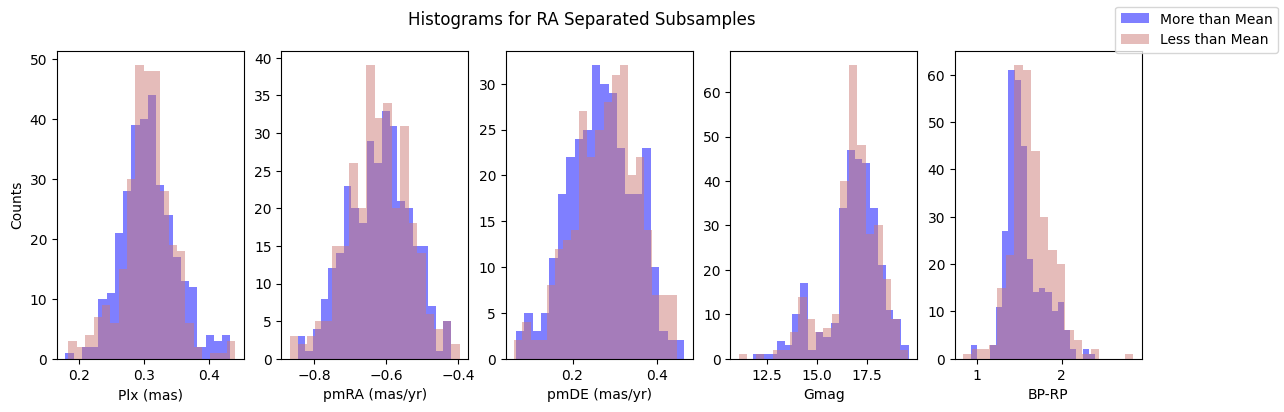

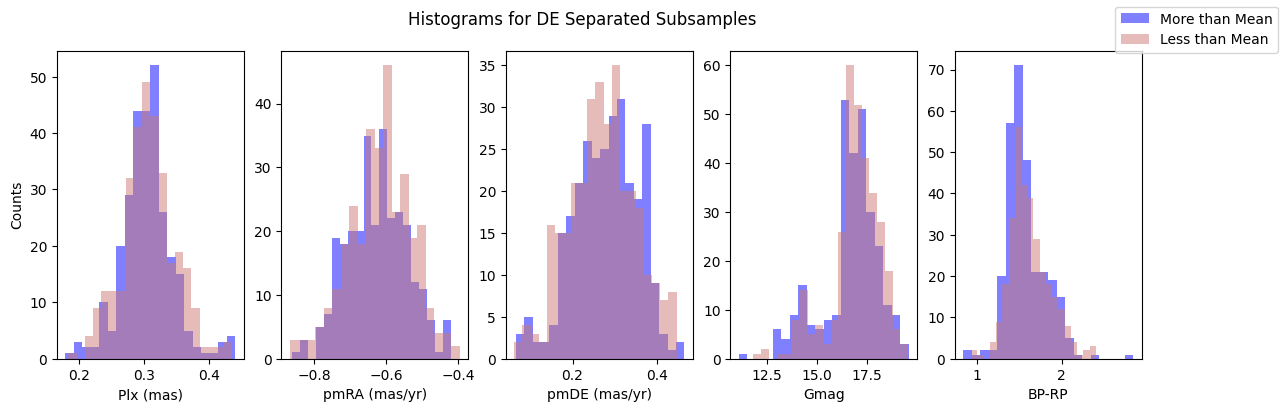

In [36]:
Hist_Ttest(stars, 'Trumpler_5')

<h4>Comments on Cluster Trumpler 5</h4>
The null hypothesis for the t tests is that the population from which each sample is drawn from (that is, the greter than mean and lower than mean samples, for both RA and DEC respectively) have the same mean. The p values from the t tests suggest that there is a variation in the distribution of the parameter BP-RP w.r.t RA a 3-$\sigma$ confidence level (p value < 0.0027). All other parameters show no significant variation with respect to position within the cluster (both wrt to RA and DE).<br>
The t test assumes that both the sample means are normally distributed - this is a fair assumption as we are considering clusters that have a large number of stars. 

<h3>Cluster Melotte 66</h3>

+--------------+-------------------------------------+--------------------------------------+
| Parameters   |   P value of RA separated subsample |   P values of DE separated subsample |
+==============+=====================================+======================================+
| Plx          |                             0.03954 |                               0.9182 |
| pmRA         |                             0.248   |                               0.8977 |
| pmDE         |                             0.7329  |                               0.9076 |
| Gmag         |                             0.8208  |                               0.5823 |
| BP-RP        |                             0.3736  |                               0.8338 |
+--------------+-------------------------------------+--------------------------------------+


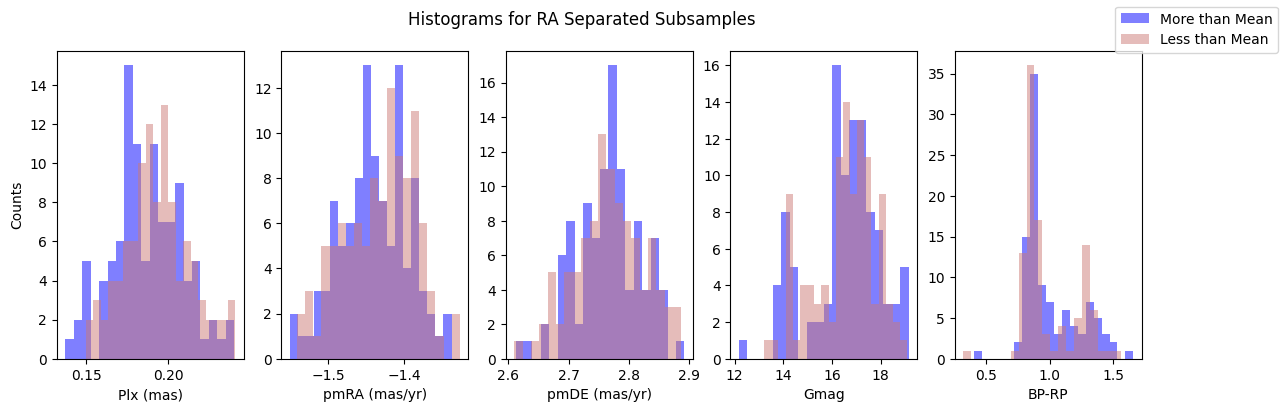

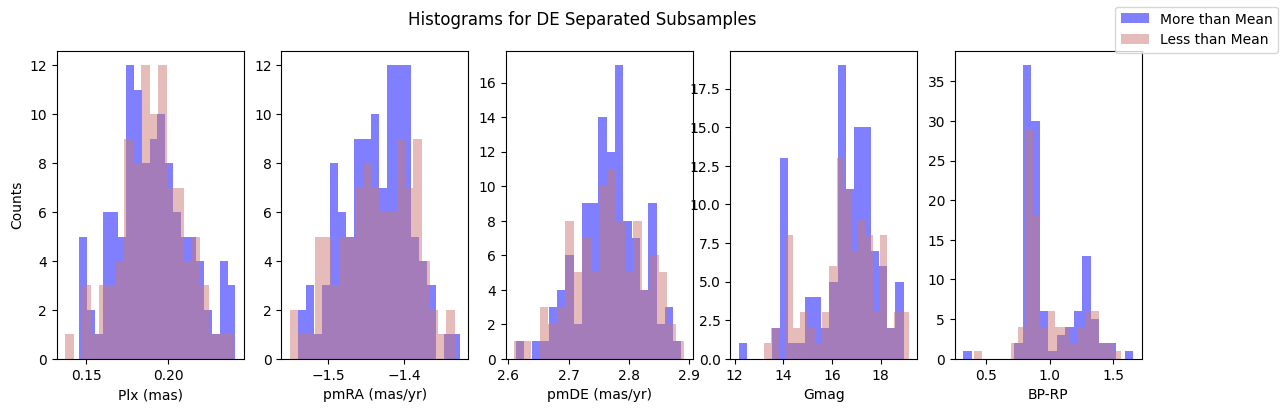

In [37]:
Hist_Ttest(stars, 'Melotte_66')

<h3>Cluster UBC 106</h3>

+--------------+-------------------------------------+--------------------------------------+
| Parameters   |   P value of RA separated subsample |   P values of DE separated subsample |
+==============+=====================================+======================================+
| Plx          |                              0.6315 |                              0.8472  |
| pmRA         |                              0.3909 |                              0.3863  |
| pmDE         |                              0.5967 |                              0.954   |
| Gmag         |                              0.8542 |                              0.306   |
| BP-RP        |                              0.2042 |                              0.03687 |
+--------------+-------------------------------------+--------------------------------------+


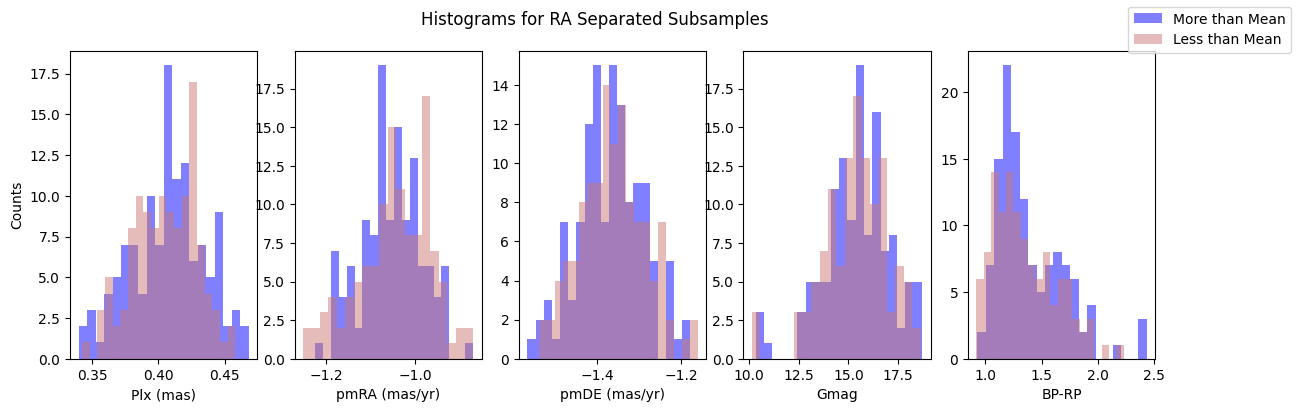

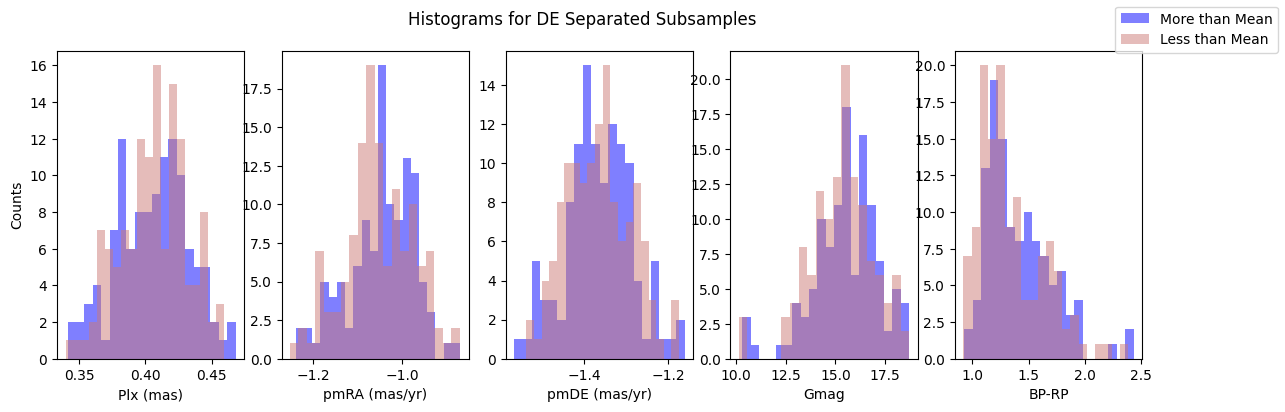

In [38]:
Hist_Ttest(stars, 'UBC_106')

<h4>Comments on the applicability of a t test</h4>
We can use a t test when either the sample itself is normally distributed or if we are taking an average over enough data points such that the Central Limit Theorem holds. In our case, most of the parameters seem to follow a normal distribution (excepting BP-RP and Gmag which look a bit skewed). For the parameters that have a a more skewed distribution, we need to be more doubtful of the applicability of the t tests. This is because, we need a much larger sample size for the central limit theorem to hold. For example, the BP-RP histograms for the cluster UBC 106 look very skewed towards a value of 1 hence we need to be more careful when applying a t test to this sample.

<h1>Task 3</h1>
Now we conduct the t tests for all the clusters in the reduced data set. We do this, again, for subsamples based on both RA and DE for each of the parameters specified. We plot a histogram of the obtained p values for each subsamples.

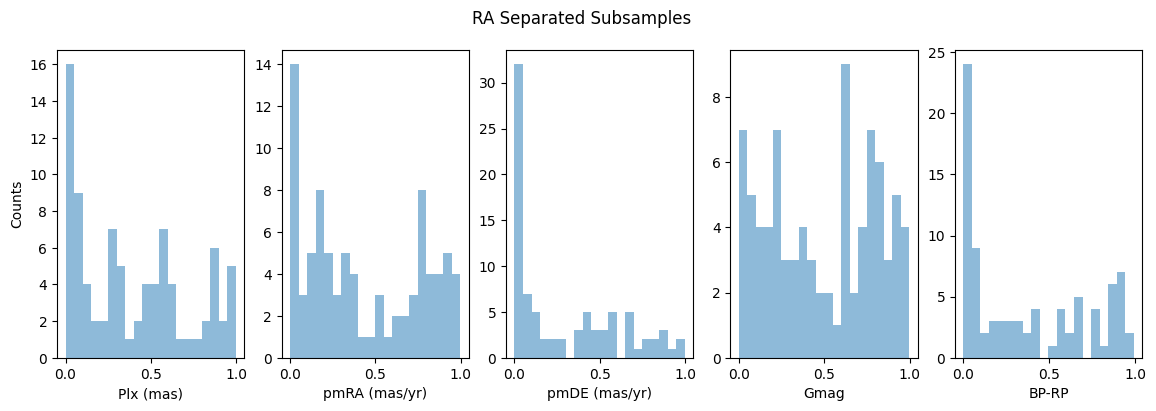

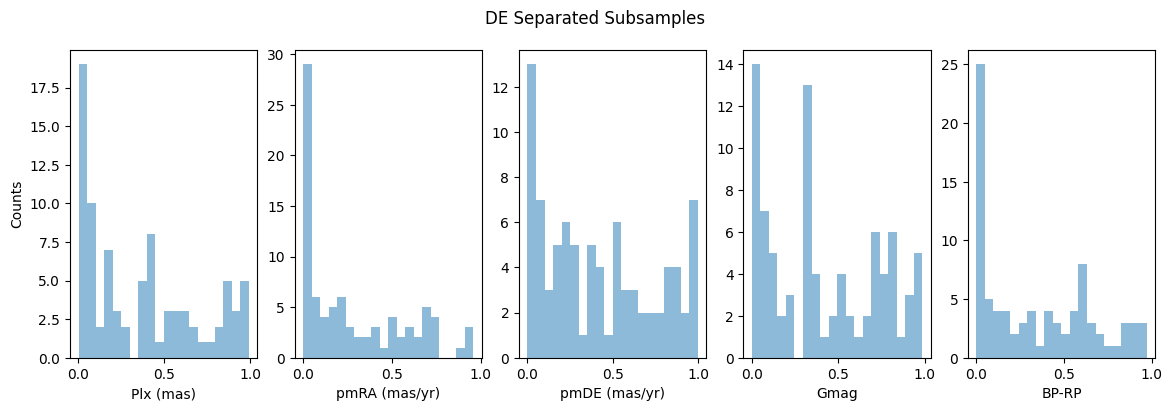

In [39]:
def calc_p_val(stars, cluster_name, params):
    """
    Calculates the p values of the tests carried out in the params specified by splitting samples based on RA and DE.
    Results formatted as:
    [RA param[0], RA param[1], RA param[2], RA param[3]... RA param[n]],
    [DE param[0], DE param[1], DE param[2], DE param[3]... DE param[n]]

    Parameters
    -------------
    stars: pandas dataframe
    - Contains information about the stars that need to be used
    cluster_name: str
    - Name of cluster being analysed
    params: list
    - List of params that need to used (have to be column headers in the stars dataframe)

    Returns
    -------------
    RA_pvals: numpy array
    - Pvals corresponding to the RA subsamples and each param
    DE_pvals: numpy array
    - Pvals corresponding to the DE subsamples and each param
    """
    selected_stars = stars[stars['Name'] == cluster_name]

    # Calculate a mean of the RA and DE of the cluster
    RA_mean = sts.tmean(selected_stars['RAdeg'])
    DE_mean = sts.tmean(selected_stars['DEdeg'])
    
    # Creating the required subsamples
    RA_morethanmean = selected_stars[selected_stars['RAdeg'] > RA_mean]
    RA_lessthanmean = selected_stars[selected_stars['RAdeg'] < RA_mean]

    DE_morethanmean = selected_stars[selected_stars['DEdeg'] > DE_mean]
    DE_lessthanmean = selected_stars[selected_stars['DEdeg'] < DE_mean]

    # T-tests
    RA_res_arr = np.zeros(len(params)) # Stores the results of the the t tests for each param for both RA and DE as a 2D array
    DE_res_arr = np.zeros(len(params))
    for count, param in enumerate(params):
        tstat_RA, pval_RA = sts.ttest_ind(RA_morethanmean[param], RA_lessthanmean[param], equal_var=True)
        RA_res_arr[count] = pval_RA
        tstat_DE, pval_DE = sts.ttest_ind(DE_morethanmean[param], DE_lessthanmean[param], equal_var=True)
        DE_res_arr[count] = pval_DE
    
    return RA_res_arr, DE_res_arr


def wrapper(stars, params):
    selected_clusters, stars_hiprob = red_data(stars)
    
    
    RA_pvals = np.zeros((1,len(params)))
    DE_pvals = np.zeros((1,len(params)))
    
    for cluster_name in selected_clusters['Name']:
    # for cluster_name in ['Trumpler_25']:
        RA_res, DE_res = calc_p_val(stars_hiprob, cluster_name, params)
        RA_pvals = np.append(RA_pvals, [RA_res], axis=0)
        DE_pvals = np.append(DE_pvals, [DE_res], axis=0)
    RA_pvals = RA_pvals[1:]
    DE_pvals = DE_pvals[1:]

    # RA Histograms
    fig, axes = plt.subplots(1, len(params),figsize=(14,4))
    fig.suptitle('RA Separated Subsamples')
    labels = ['Plx (mas)', 'pmRA (mas/yr)', 'pmDE (mas/yr)', 'Gmag', 'BP-RP']
    for count, axis in enumerate(axes):
        # print(RA_pvals)
        axis.hist(RA_pvals[:,count], bins=20, alpha=.5)
        axis.set_xlabel(labels[count])
        if count == 0:
            axis.set_ylabel('Counts')

    fig, axes = plt.subplots(1,len(params),figsize=(14,4))
    fig.suptitle('DE Separated Subsamples')
    for count, axis in enumerate(axes):
        axis.hist(DE_pvals[:,count], bins=20, alpha=.5)
        axis.set_xlabel(labels[count])
        if count == 0:
            axis.set_ylabel('Counts')
    return RA_pvals, DE_pvals

params = ['Plx', 'pmRA', 'pmDE', 'Gmag', 'BP-RP']
pvals_RA, pvals_DE = wrapper(stars, params)

<h1>Task 4</h1>
We can now conduct a K-S test to figure out whether or not the distribution of p values we obtained are consistent with a uniform distribution. This is done for the set of p values obtained for each parameter in RA and DE.

In [40]:
def KStest(RA_pvals, DE_pvals, params):
    kstest_results_RA = np.zeros(len(params))
    kstest_results_DE = np.zeros(len(params))

    # For RA separated samples
    for count in range(len(params)):
        kstest_results_RA[count] = sts.kstest(RA_pvals[:,count], 'uniform').pvalue
    
    # For DE separated samples
    for count in range(len(params)):
        kstest_results_DE[count] = sts.kstest(DE_pvals[:,count], 'uniform').pvalue

    Headers = ['P values for Plx', 'P values for pmRA', 'P values for pmDE', 'P values for Gmag', 'P values for BP-RP']
    rowIDs = ['RA Subsamples', 'DE Subsamples']
    print('KS Test results for all p values:')
    print(tabulate([kstest_results_RA, kstest_results_DE], headers=Headers, showindex=rowIDs, tablefmt="outline"))

    # Now for P>0.01
    kstest_results_RA = np.zeros(len(params))
    kstest_results_DE = np.zeros(len(params))

    # For RA separated samples
    for count in range(len(params)):
        # Below code for formatting to 3 sf taken from stackeroverflow
        kstest_results_RA[count] = '%f' % float('%.3g' % float(sts.kstest(RA_pvals[:,count][RA_pvals[:,count]>0.01], 'uniform').pvalue))
    
    # For DE separated samples
    for count in range(len(params)):
        # Below code for formatting to 3 sf taken from stackeroverflow
        kstest_results_DE[count] = '%f' % float('%.3g' % sts.kstest(DE_pvals[:,count][DE_pvals[:,count]>0.01], 'uniform').pvalue)
    print('\nKS Test results for p values > 0.01:')
    print(tabulate([kstest_results_RA, kstest_results_DE], headers=Headers, showindex=rowIDs, tablefmt="outline"))

KStest(pvals_RA, pvals_DE, params)

KS Test results for all p values:
+---------------+--------------------+---------------------+---------------------+---------------------+----------------------+
|               |   P values for Plx |   P values for pmRA |   P values for pmDE |   P values for Gmag |   P values for BP-RP |
+===============+====================+=====================+=====================+=====================+======================+
| RA Subsamples |        0.000647982 |         0.00960781  |         1.96123e-11 |          0.537667   |          7.35971e-07 |
| DE Subsamples |        1.08681e-05 |         1.01333e-10 |         0.0171779   |          0.00257588 |          4.05347e-06 |
+---------------+--------------------+---------------------+---------------------+---------------------+----------------------+

KS Test results for p values > 0.01:
+---------------+--------------------+---------------------+---------------------+---------------------+----------------------+
|               |   P values for

<h3>Comments on Task 4</h3>
If we include all p values, the parameters Plx, pmDE, BP-RP have values below the 3-$\sigma$ confidence level in the RA subsample and the parameters Plx, pmRA, Gmag and BP-RP have values below the 3-$\sigma$ confidence level in the DE subsamples. <br>
When we exclude values of p <= 0.01 (from the t test), the parameter pmDE has a value below the 3-$\sigma$ confidence level in the RA subsample and the parameters Plx and pmRA have p values (from the K-S test) below the 3-$\sigma$ confidence level in the DE subsample.<br>
Excluding the extremely low p values of the t test reduces the number of parameters that show a dependance on the position in the cluster. This suggests that the results of K-S test were/are being significantly influenced by the outliers and that it is likely that the results were due to primarily the outliers